Load the `ISLR2` and `tidymodels` packages.

In [1]:
install.packages("ISLR")

Installing package into 'C:/Users/agung/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'ISLR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\agung\AppData\Local\Temp\RtmpmCVhlq\downloaded_packages


In [5]:
library("tidymodels")
library("ISLR")

Take a look at the `Smarket` dataset which comes from the ISLR2 package (also described in [the book](https://www.statlearning.com/)). 

In [6]:
glimpse(Smarket)

Rows: 1,250
Columns: 9
$ Year      <dbl> 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, …
$ Lag1      <dbl> 0.381, 0.959, 1.032, -0.623, 0.614, 0.213, 1.392, -0.403, 0.…
$ Lag2      <dbl> -0.192, 0.381, 0.959, 1.032, -0.623, 0.614, 0.213, 1.392, -0…
$ Lag3      <dbl> -2.624, -0.192, 0.381, 0.959, 1.032, -0.623, 0.614, 0.213, 1…
$ Lag4      <dbl> -1.055, -2.624, -0.192, 0.381, 0.959, 1.032, -0.623, 0.614, …
$ Lag5      <dbl> 5.010, -1.055, -2.624, -0.192, 0.381, 0.959, 1.032, -0.623, …
$ Volume    <dbl> 1.1913, 1.2965, 1.4112, 1.2760, 1.2057, 1.3491, 1.4450, 1.40…
$ Today     <dbl> 0.959, 1.032, -0.623, 0.614, 0.213, 1.392, -0.403, 0.027, 1.…
$ Direction <fct> Up, Up, Down, Up, Up, Up, Down, Up, Up, Up, Down, Down, Up, …


Let's see if we can predict when the market will be "Up" or "Down" (see the "Direction" variable of `Smarket`). We use the following variables as predictors:

- Lag1: *percentage returns from previous before*
- Volume: *the number of shares traded on the previous day, in billions*

First we need to split our data into training and test subsets. 

Plot the number of observations per year using a bar chart.

In [17]:
smarket_training <- Smarket |> select(Direction, Lag1, Volume) |> drop_na()
smarket_training |> head()

rec <- recipe(Direction ~ Lag1, data = smarket_training)
rec_prepped <- prep(rec, smarket_training)

rec_prepped |> juice() |> head()

,Direction,Lag1,Volume
,<fct>,<dbl>,<dbl>
1,Up,0.381,1.1913
2,Up,0.959,1.2965
3,Down,1.032,1.4112
4,Up,-0.623,1.2760
5,Up,0.614,1.2057
6,Up,0.213,1.3491


Lag1,Direction
<dbl>,<fct>
0.381,Up
0.959,Up
1.032,Down
-0.623,Up
0.614,Up
0.213,Up


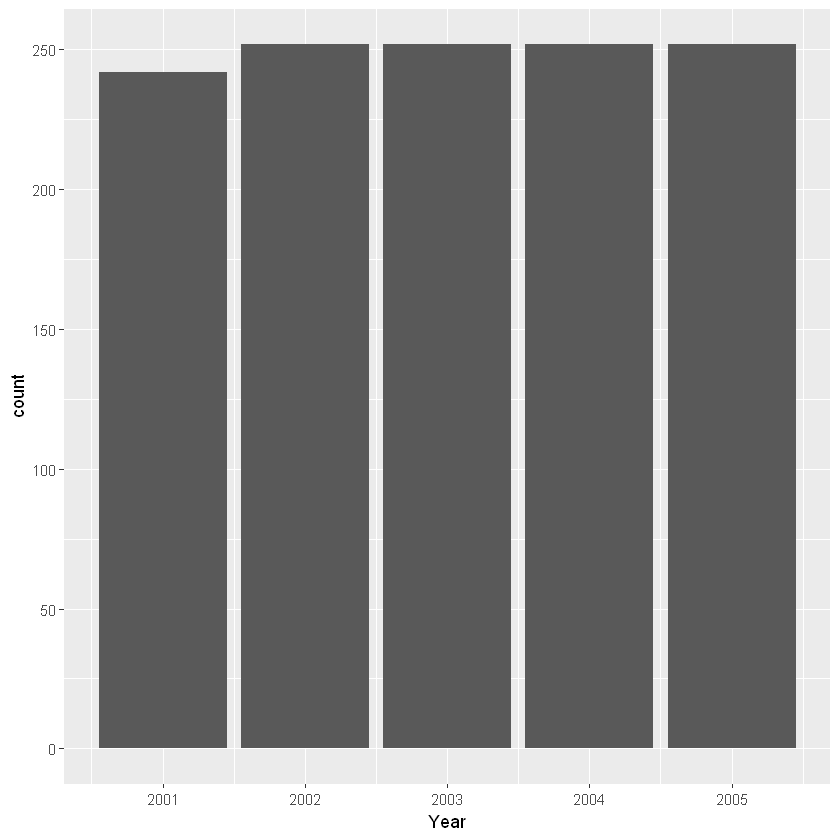

In [16]:
ggplot(Smarket, aes(x = Year)) +
  geom_bar()

Run the following cell after substituting `PUT_MOST_RECENT_YEAR_HERE` with a value deduced from the chart above. Why is this a sensible way to split our data?

In [15]:
Smarket_train = Smarket |> filter(Year < 2005)
Smarket_test = Smarket |> filter(Year == 2005)

Generate a model to predict market direction.
- Use the `logistic_reg()` function from `tidymodels` and the "glm" engine.
- Use the training data from above and call your fitted model `mod_fit`.
- Use `Direction ~ Volume + Lag1` as the formula.

In [31]:
rec_train <- recipe(Direction ~ Volume + Lag1, data = Smarket_train)
rec_train_prepped <- prep(rec_train, Smarket_train)

mod_train <- logistic_reg() |> set_engine('glm')
mod_train_fit <- mod_train |> fit(Direction ~ Volume + Lag1, data = Smarket_train)
#mod_train_fit <- mod_train |> fit(Direction ~ Volume + Lag1, juice(Smarket_train))

tidy(mod_train_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.17895928,0.33084304,0.5409190,0.5885634
Volume,-0.10736808,0.23747318,-0.4521272,0.6511774
Lag1,-0.05332657,0.05173953,-1.0306737,0.3026938


In [32]:
rec_train <- recipe(Direction ~ Volume + Lag1, data = Smarket_train)
rec_train_prepped <- prep(rec_train, Smarket_train)

mod_train <- logistic_reg() |> set_engine('glm')
#mod_train_fit <- mod_train |> fit(Direction ~ Volume + Lag1, data = Smarket_train)
mod_train_fit <- mod_train |> fit(Direction ~ Volume + Lag1, juice(rec_train_prepped))

tidy(mod_train_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.17895928,0.33084304,0.5409190,0.5885634
Volume,-0.10736808,0.23747318,-0.4521272,0.6511774
Lag1,-0.05332657,0.05173953,-1.0306737,0.3026938


In [20]:
rec_test <- recipe(Direction ~ Volume + Lag1, data = Smarket_test)
rec_test_prepped <- prep(rec_test, Smarket_test)

mod_test <- logistic_reg() |> set_engine('glm')
mod_test_fit <- mod_test |> fit(Direction ~ Volume + Lag1, juice(rec_test_prepped))

tidy(mod_test_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.2075560,0.7217281,-0.2875820,0.7736667
Volume,0.2370493,0.3714734,0.6381326,0.5233874
Lag1,-0.3088390,0.1998480,-1.5453695,0.1222569


Run the following code to predict from your test data and generate a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). When the market is "Up" how often does your model predict the same?

In [34]:
augment(mod_train_fit, Smarket_test) |>
  conf_mat(Direction, .pred_class)

          Truth
Prediction Down Up
      Down   84 95
      Up     27 46

Run the following code to calculate the error rate for the model.

In [35]:
augment(mod_train_fit, Smarket_test) |>
  summarize(error_rate = mean(Direction != .pred_class))

error_rate
<dbl>
0.484127


Run the following code to calculate the error rate for a simple model that always predicts "Up". Is the error rate better than your logistic regression model?

In [36]:
Smarket_test |>
  summarise(error_rate = mean(Direction != "Up"))

error_rate
<dbl>
0.4404762
